<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/knn_create_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN: Create Model
## In this notebook we will create an ensemble of KNN prediction models to estimate % tree canopy cover using a well spread and balanced sample.

### Objectives
- Learn about KNN
- Learn how to build an ensemble
- Apply the model to estimate Forest Canopy Cover and standard error in both 2016 and 2024

### Datasets
- Landsat 8 imagery(ls8.tif)
- Forest Canopy Cover (cf1.tif)
- Sample & Validation datasets (sb_sample.shp.zip): columns [ls8_1 - ls8_7 and cf]; n=150; n=9,850
  - ls8 -> spectral reflectance for (blue,green,red,nir,thermal,mid_ir1,mid_ir2)
  - cf1 -> Percent Forest Canopy Cover


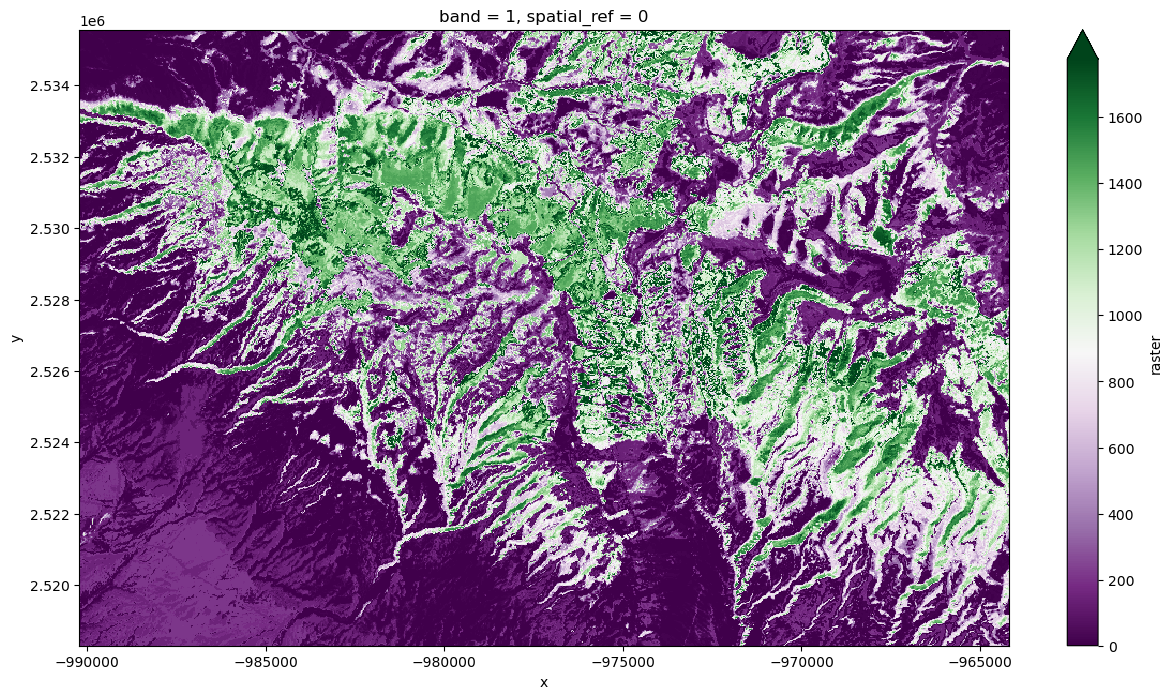

## Install packages

In [ ]:
!pip install mapclassify
!pip install osmnx
!pip install raster_tools==0.9.2
!pip install planetary-computer
!pip install pystac-client
!pip install stackstac
!pip install owslib
!pip install hilbertcurve

### Steps
1. Get the data and explore the sample
2. Create a EKNN model
3. Use the EKNN to estimate Tree Canopy Cover
4. Evaluate the model

by John Hogland 3/26/2024

## Import packages

In [ ]:
#get packages
from raster_tools import Raster,general,clipping
import geopandas as gpd, pandas as pd, osmnx as ox

import numpy as np, os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline

## Step 1: Get the data and explore the sample
In this step we will extract data from planetary computer, create a well spread and balanced sample, extract Landsat 8 image values, and create a scatter plot matrix of the relationship among all variables.

### Create a large simple random sample definition

In [ ]:
#Create a random sample definition
def get_random_sample(geom_p, n=1000):
    """
    produces a random sample given a geometry

    parameters:
    geom_p = (polygon) project polygon
    n = number of observations

    returns: geodataframe of point locations

    """
    xmin, ymin, xmax, ymax = geom_p.total_bounds
    xdif = xmax - xmin
    ydif = ymax - ymin
    pnts_lst = []
    while len(pnts_lst) < n:
        x = (np.random.random() * xdif) + xmin
        y = (np.random.random() * ydif) + ymin
        pnt = geometry.Point([x, y])
        if pnt.intersects(geom_p).values:
            pnts_lst.append(pnt)

    dic = {"geometry": pnts_lst}
    gdf = gpd.GeoDataFrame(dic, crs=geom_p.crs)

    return gdf


### Create a large simple random sample

In [ ]:
#use OpenStreetMaps to get the boundary of the NF
nf=ox.geocode_to_gdf('Custer Gallatin National Forest, MT, USA')

#get first polygon of the NF
nfe=nf.explode()
nf1=gpd.GeoSeries(nfe.geometry.iloc[10],crs=nf.crs)

#project to Albers equal area
nf1p=nf1.to_crs(5070)

#us random sample function to create 10,000 locations within the nf1
pnts=get_random_sample(nf1p,10000)

#Visualize the nf1 and sample locations
m=nf1p.explore()
m=pnts.explore(m=m,color='yellow')
m

### Create definitions to get remotely sensed data

In [ ]:
import requests, urllib, pystac_client, stackstac, planetary_computer
from owslib.wcs import WebCoverageService

#create definition to mosaic stac data
def mosaic_stac(xr):
    return stackstac.mosaic(xr)

#create definition to extract stac data
def get_stac_data(geo,url="https://planetarycomputer.microsoft.com/api/stac/v1",name="sentinel-2-l2a",res=30,crs=5070,**kwarg):
    '''
    gets tiled data from planetary computer as a dask backed xarray that intersects the geometry of the point, line, or polygon

    geo = (polygon) geometry bounding box (WGS84)
    url = (string) base url to planetary computer https://planetarycomputer.microsoft.com/api/stac/v1
    name = (string) catelog resource
    qry =  (dictoinary) of property values {'eo:cloud_cover':{'lt':1}}
    res = (tuple of numbers) output resolution (x,y)
    crs = (int) output crs
    dt = (string) data time intervale e.g., one month: 2023-06, range: 2023-06-02/2023-06-17
    limit = (int) max number of items to return

    returns (xarray data array and stac item catalog)
    '''
    catalog = pystac_client.Client.open(url, modifier=planetary_computer.sign_inplace)
    srch = catalog.search(collections=name, intersects=geo, **kwarg)
    ic = srch.item_collection()
    if(len(ic.items)>0):
        xra = stackstac.stack(ic,resolution=res,epsg=crs)
        xra = mosaic_stac(xra)
    else:
        xra=None

    return xra,ic

#Create definition to extract image service data
def get_image_service_data(url, ply, out_prefix,res=30,outSR=""):
    '''
    extracts a list of images from a image service given a url, polygon, and output prefix name

    url = (string) path to image service e.g., url=r'https://lfps.usgs.gov/arcgis/rest/services/Landfire_LF230/US_230EVT/ImageServer'
    ply = (geoseries or geodataframe) of the study area
    out_prefix = (string) prefix used to save each image
    '''
    layerInfo=requests.get(url+'?f=pjson')
    dic=layerInfo.json()
    #print(dic)
    spr=dic['spatialReference']
    m_width=dic['maxImageWidth']
    m_height=dic['maxImageHeight']
    fitem=next(iter(spr))
    ply2=ply.to_crs(spr[fitem])

    xmin,ymin,xmax,ymax=ply2.total_bounds

    wcells=int((xmax-xmin)/res)
    hcells=int((ymax-ymin)/res)

    if(wcells<m_width):
        m_width=wcells

    if(hcells<m_height):
        m_height=hcells


    wcells_l=np.arange(0,wcells,m_width)
    hcells_l=np.arange(0,hcells,m_height)

    xmax2=xmin
    ymax2=ymin

    tile=1

    rs_lst=[]
    for w in wcells_l:
        for h in hcells_l:
            xmax2 = (m_width*res+xmax2)
            ymax2 = (m_height*res+ymax2)

            qry = url+'/exportImage?'
            parm = {
                'f':'json',
                'bbox':','.join([str(xmin),str(ymin),str(xmax2),str(ymax2)]),
                'size':str(m_width) + ',' + str(m_height),
                'imageSR':outSR,
                'format':'tiff'
            }
            #print(parm['bbox'])
            response=requests.get(qry,parm)
            if response.status_code == 200:
                img_url=response.json()['href']
                outname=out_prefix + str(tile) + '.tif'
                urllib.request.urlretrieve(img_url, outname)
                rs_lst.append(Raster(outname))
                tile+=1

    return rs_lst

# Create definition for WCS download
def get_wcs_data(url,ply,service_name='mrlc_download__nlcd_tcc_conus_2021_v2021-4',out_prefix = 'tcc'):
    '''
    Extracts saves an image from a WCS given url, polygon boundary, and service name. Images are saved in the same location as the notebook.
    url = (string) path to wcs e.g. 'https://www.mrlc.gov/geoserver/mrlc_download/nlcd_tcc_conus_2021_v2021-4/wcs?'
    ply = (geoseries or geodataframe) of the study area
    service_name = (string) name of the service e.g. mrlc_download__nlcd_tcc_conus_2021_v2021-4
    out_prefix = (string) prefix used to save each image

    returns a Raster object
    '''
    wcs=WebCoverageService(url)
    tcc=wcs.contents[service_name]
    bbox=tuple(ply.total_bounds)
    subsets=[('X',bbox[0],bbox[2]),('Y',bbox[1],bbox[3])]
    rsp=wcs.getCoverage(identifier=[tcc.id],subsets=subsets,format='geotiff')
    outpath='./'+out_prefix+'.tif'
    with open(outpath,'wb') as file:
        file.write(rsp.read())

    return Raster(outpath)

### Extract the spectral values from the imagery

In [ ]:
from raster_tools import zonal

#get stac data landsat data
if(not os.path.exists('ls82016.tif')):
    xmin,ymin,xmax,ymax=nf1p.buffer(200).total_bounds
    ls30, ic =get_stac_data(nf1.geometry[0],"https://planetarycomputer.microsoft.com/api/stac/v1",name="landsat-c2-l2",res=30,crs=5070,datetime='2016-06-15/2016-06-30',query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},limit=1000)
    ls30s=Raster(ls30.sel(band=['red', 'green', 'blue','nir08', 'lwir11','swir16', 'swir22'],x=slice(xmin,xmax),y=slice(ymax,ymin)))
    ls30s=ls30s.save('ls82016.tif')

#get REST data forest canopy cover
# if(not os.path.exists('cf1.tif')):
#     url=r'https://apps.fs.usda.gov/fsgisx01/rest/services/RDW_LandscapeAndWildlife/NLCD_2016_TreeCanopyCover_CONUS/ImageServer'
#     im_lst=get_image_service_data(url=url,ply=nf1,out_prefix='cf',res=30,outSR=5070)
#     ccf_rs=im_lst[0]

outpath='cf1.tif'
if(not os.path.exists(outpath)): #if the 2016 tree canopy cover file does not exits, download it
    url=r'https://www.mrlc.gov/geoserver/mrlc_download/nlcd_tcc_conus_2016_v2021-4/wcs?'
    sn='mrlc_download__nlcd_tcc_conus_2016_v2021-4'
    get_wcs_data(url=url,ply=nf1p,service_name=sn,out_prefix='cf1')


#Extract point data
ccf_rs=Raster('cf1.tif')
ccf_rs=ccf_rs
ls30s=Raster('ls82016.tif')

ls_tbl=zonal.extract_points_eager(pnts,ls30s,'ls8',axis=1).compute()
pred=ls_tbl.columns

ccf_tbl=zonal.extract_points_eager(pnts,ccf_rs,'cf',axis=1).compute()

#set null values -9999 to 0
vls=ccf_tbl['cf_1']
ccf_tbl['cf']=vls.where(vls>0,0)


#Join values to pnts geodataframe
ls_tbl['cf']=ccf_tbl['cf']
bsmp=gpd.GeoDataFrame(ls_tbl,geometry=pnts.reset_index(drop=True))

#visualize the data
display(bsmp)
pd.plotting.scatter_matrix(bsmp,figsize=(15,15))

### Create systematic random sample using a sorted list and Hilbert distance (n=150)
#### Create definition

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from hilbertcurve.hilbertcurve import HilbertCurve
def get_plots(bsmp,clm_nms,n=250,sys=False,euclidean=True,ordinate=True):
    '''
    bsmp (dataframe) =  population dataframe
    subarea (polygon geodataframe) = geodataframe of accessible areas
    clm_nms (list of strings) = list of column names used as predictor variables
    n (int) = sample size
    sys (bool) = used to determine if we are using a systematic random sample from a sorted list of distances or a simple random sample
    euclidean (bool) = used to determine how distance is calculated
    ordinate (bool) = specifies if Standard Scaler and PCA (True) or MinMaxScaler procedure is used (False) when using Hilbert distance


    returns a geodataframe of selected observations
    '''

    if(not ('plotid' in list(bsmp.columns))): bsmp['plotid']=bsmp.index

    #Normalize and center variable values
    X=bsmp[clm_nms]
    if(ordinate):
        ss=StandardScaler()
        ss.fit(X)
        X2=ss.transform(X)

        #Perform PCA, transform scaled values, and perform K-means classification
        pca=PCA()
        pca.fit(X2)
        X3=pca.transform(X2)*1000
        clm_nms2=[]
        for c in range(X3.shape[1]):
            clm_nms2.append('comp_' + str(c+1))
    else:
        mss=MinMaxScaler()
        mss.fit(X)
        X3=mss.transform(X)*1000
        clm_nms2=[]
        for c in range(X3.shape[1]):
            clm_nms2.append('s_' + str(c+1))

    bsmp=bsmp.join(pd.DataFrame(X3,columns=clm_nms2))

    if(sys):
        #calc distance, sort, and create random start to get ids
        X = bsmp[clm_nms2]
        if(euclidean):
          dist=((X-X.min(axis=0)).pow(2)).sum(axis=1)
        else:
          if(ordinate):
            X2=((X-X.min())).astype('int32')
          else:
            X2=X.astype('int32')

          p=int(np.log2(np.max(X2)))+1 #axes length
          n2=X2.shape[1]
          hilbert_curve = HilbertCurve(p, n2)
          dist = pd.Series(hilbert_curve.distances_from_points(X2.values),dtype='object')

        bsmp['dist']=dist

        id_sort=dist.sort_values()
        N=X.shape[0]
        skp=N/n
        st=np.random.randint(0,int(skp))
        idlst=np.arange(st,N,skp).astype('int32')
        ids2=id_sort.iloc[idlst].index

    else:
        #create a random sample from all locations
        ids2=np.random.choice(bsmp.index,n,replace=False)

    #subset the random sample (rsmp)
    rsmp=bsmp[bsmp.index.isin(ids2)]

    return rsmp,bsmp

### Create the well spread and balanced sample and save

In [ ]:
if(not os.path.exists('sb_sample.shp')):
  smp_t,bsmp_d = get_plots(bsmp=bsmp,clm_nms=pred,n=150,sys=True,euclidean=False,ordinate=True)
  smp_t[list(pred)+['cf','geometry']].to_file('sb_sample.shp')
  bsmp[~bsmp['plotid'].isin(smp_t['plotid'])].to_file('validation.shp')



### Visualize the sample

In [ ]:
# get the data
gdf=gpd.read_file('sb_sample.shp')

# map the national forest boundary and sample locations
m=nf1p.explore()
m=gdf.explore(m=m,color='yellow')
m


### Look at the relationship among variables

In [ ]:
# get the response and predictor variables
pred=gdf.columns[:-2]

# create a scatter plot matrix of all variables
pd.plotting.scatter_matrix(gdf,figsize=(15,15))

## Step 2: Create EKNN
In this step we will transform our predictor variables into normalized independent components and then use those components to create an ensemble of KNN regression models (EKNN) that can be used to estimate mean cubic feet of lumber and error per acre or canopy cover and error depending on the response variable.  

In [ ]:
# Create a scale function that centers and scales values based on means and standard deviation (Standard Scaler)
_scaler=StandardScaler()

# Create a PCA function to perform a PCA on scaled variables (independent components)
_pca=PCA()

# Create a base KNN regression function that can be used to estimate cover
_knn=KNeighborsRegressor(n_neighbors=5) #note we are averaging five neighbors

# Separate data into y (cubic feet/acre or canopy cover) and x (landsat predictor variables values)
y=gdf['cf'].values
X=gdf[pred].values

# Create a pipeline for scaler and PCA component and transform values
pipe = Pipeline(steps=[("scaler", _scaler), ("pca", _pca)]).fit(X)
X2=pipe.transform(X)

# Create EKNN using a Bagging Regressor
eknn=BaggingRegressor(estimator=_knn,n_estimators=50, oob_score=True).fit(X2,y)

# Create EKNN stander error estimate from EKNN
elst=[]
for e in eknn.estimators_:
    elst.append(e.predict(X2))

pdf=pd.DataFrame(elst)
p=pdf.mean(axis=0)
ste=pdf.std(axis=0)



## Evaluate the model

In [ ]:
#create a data frame of transformed values
clmns=[]
for c in range(7):
    clmns.append('comp'+str(c))

tdf=pd.DataFrame(X2,columns=clmns)
tdf['cf']=y

### Look at the transformed variables

In [ ]:
#look at scatter plot matrix of predictor variables
pd.plotting.scatter_matrix(tdf,figsize=(15,15))

### Look at the model fit

In [ ]:
# Look at the oob
print('OOB = ',eknn.oob_score_)

# Calculate the RMSE and print
gdf['pred']=p
gdf['ste']=ste
print('R squared =',gdf[['pred','cf']].corr().iloc[0,1]**2)

print('RMSE = ',np.sqrt(((gdf['pred']-gdf['cf'])**2).mean()))

# Plot observed vs predicted
ax=gdf.plot.scatter(x='pred',y='cf')

# Create one to one line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# Plot line on scatter plot
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

### Look at distribution of standard error

In [ ]:
# Plot ste vs predicted
ax=gdf.plot.scatter(x='cf',y='ste',)

### Look at model fit for validation data set

In [ ]:
#Separate data into y (Percent Canopy Cover ) and x (landsat predictor variables values)
gdfv=gpd.read_file('validation.shp')
yv=gdfv['cf'].values
Xv=gdfv[pred].values

X2v=pipe.transform(Xv)


# Create EKNN stander error estimate from EKNN
gdfv['pred']=eknn.predict(X2v)

print('R squared =',gdfv[['pred','cf']].corr().iloc[0,1]**2)

print('RMSE = ',np.sqrt(((gdfv['pred']-gdfv['cf'])**2).mean()))

# Plot observed vs predicted
ax=gdfv.plot.scatter(x='pred',y='cf')

# Create one to one line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# Plot line on scatter plot
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)


## Step 3: Use EKNN to create raster surfaces of mean Forest Canopy Cover and standard error
### Estimate mean Percent Forest Canopy Cover

In [ ]:
# Read in landsat raster
pred_rs_2016=Raster('ls82016.tif')
# Transform landsat raster to components
pipe_a=general.ModelPredictAdaptor(pipe,'transform')
pred_tr=pred_rs_2016.model_predict(pipe_a,X2.shape[1]).eval()
# Estimate mean CF
mcf=pred_tr.model_predict(eknn).eval()

### Estimate standard error

In [ ]:
# create a new function to estimate standard error
def ste(X):
    elst=[]
    for e in eknn.estimators_:
        elst.append(e.predict(X))

    pdf=pd.DataFrame(elst)
    return pdf.std(axis=0)

# add the function to EKNN
eknn.ste=ste

# use the adapter to convert the new function into a Raster function
eknn_ste=general.ModelPredictAdaptor(eknn,'ste')

# Estimate standard error
stecf=pred_tr.model_predict(eknn_ste).eval()


### Plot mean estimates

In [ ]:
mcf.plot(figsize=(15,8),cmap='PRGn',robust=True)

### Plot Standard Error

In [ ]:
stecf.plot(figsize=(15,8),cmap='Reds',robust=True)

## Evaluate the Raster estimates
Look at the difference between observed and predicted values and determine RMSE

In [ ]:
# Read in CF raster
cf_rs=Raster('cf1.tif').set_null_value(255) #set the null value to 255
cf_rs=cf_rs.where(cf_rs.to_null_mask()<1,0) #set null value to zero

# Reproject and snap to mcf raster
cf_rs=Raster(cf_rs.xdata.rio.reproject_match(mcf.xdata))

# Set null values to zero to match model assumption
cf_rs=cf_rs.where(~cf_rs.to_null_mask(),0)

# Subtract raster values
dif=cf_rs-mcf

#Calculate RMSE
rmse=np.sqrt((dif**2).mean()).compute()

#Print RMSE and the difference surface
print("RMSE = ",rmse)
dif.plot(figsize=(15,8),cmap='coolwarm',robust=True)

### Determine where mean falls within  95% CL

In [ ]:
ch=(np.abs(dif)>(1.96*stecf))
ch.plot(figsize=(15,8))

## Compare population estimate to true value
### Using just the sample

In [ ]:
import scipy

n=y.shape[0]
m=y.mean()
se=y.std()/np.sqrt(n)
tvl=scipy.stats.t.ppf(0.975,n-1)
t_p=clipping.clip(nf1p,cf_rs).mean().compute() #need to clip to nf1p study area boundary

print('Sample mean =',m)
print('Sample standard error =',se)
print('n =',n)
print('95% CL =',m-tvl*se,m+tvl*se)
print('True population mean =',t_p)


### Using the EKNN and component scores

In [ ]:
# create a definition to calculate mean estimate for each KNN within the EKNN and store in a list
def get_sem(mdl,rs,clip=None):
  m_lst=[]
  for k in mdl.estimators_:
    est=rs.model_predict(k)
    if(clip is None):
      estc=est
    else:
      estc=clipping.clip(clip,est) #need to clip to nf1p study area boundary

    m_lst.append(estc.mean().compute())

  return m_lst

In [ ]:
# Calculate estimates (mean and se) and graph distribution of ensemble
m_lst=get_sem(eknn,pred_tr,nf1p)
m2=np.mean(m_lst)
se2=np.std(m_lst)
n2=len(m_lst)

print('EKNN mean =',m2)
print('EKNN standard error =',se2)
print('n =', n2)
print('95% CL =',np.percentile(m_lst,[2.75,97.5]))
print('True populaton mean =',t_p)


In [ ]:
# plot distribution of means for eknn
p=pd.DataFrame(m_lst,columns=['est']).hist()
display(p)
p2=nf1p.plot(color='lightblue',figsize=(15,10),zorder=1)
p2=gdf.plot(ax=p2,color='yellow',zorder=2)
display(p2)

## Outside the spatial domain

In [ ]:
elst=get_sem(eknn,pred_tr)
print('Design Population estimate (Cover)=',m)
print('EKNN Population estimate (Cover)= ',np.mean(elst))
print('EKNN Standard error estimate (Cover)=',np.std(elst))
print('True population value (Cover)= ', cf_rs.mean().compute())
p=nf1p.plot(facecolor="none",edgecolor='red',figsize=(15,10),zorder=1)
p=gdf.plot(ax=p,color='yellow',zorder=2)
p=cf_rs.plot(ax=p,cmap='PRGn',robust=True,zorder=0)


### Subarea within the spatial domain

In [ ]:
#use one of the plot locations and buffer out to approximately 78 ha to make a operational stand
stnd=gdf.iloc[5:6,:].buffer(500)
p=stnd.plot(facecolor="none",edgecolor='yellow',linewidth=2,zorder=2,figsize=(15,10))
p=nf1p.plot(ax=p, facecolor="none",edgecolor='red',zorder=1)
p=cf_rs.plot(ax=p,cmap='PRGn',robust=True,zorder=0)
print('Hectares =',stnd.area/10000)

In [ ]:
tcf=clipping.clip(stnd,cf_rs).mean().compute()
elst=get_sem(eknn,pred_tr,stnd)

In [ ]:
ecf=np.mean(elst)
ecfse=np.std(elst)
print('Sample mean =',(gdf[gdf.intersects(stnd.union_all())]['cf']).mean())
print('Estimated mean Cover =',ecf)
print('Estimated 95% CL (Cover) =',np.percentile(elst,[2.75,97.5]))
print('True mean CF =',tcf)

## Project into the future
### Getting Landsat data for 2024


#### Get data for 2024

In [ ]:
pred_rs_2016=Raster('ls82016.tif')
if(not os.path.exists('ls82024.tif')):
    xmin,ymin,xmax,ymax=nf1p.buffer(200).total_bounds
    ls30, ic =get_stac_data(nf1.geometry[0],"https://planetarycomputer.microsoft.com/api/stac/v1",name="landsat-c2-l2",res=30,crs=5070,datetime='2024-07-15/2024-07-31',query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},limit=1000)
    ls30s=Raster(ls30.sel(band=['red', 'green', 'blue','nir08', 'lwir11','swir16', 'swir22'],x=slice(xmin,xmax),y=slice(ymax,ymin)))
    ls30s=ls30s.save('ls82024.tif')

pred_rs_2024=Raster('ls82024.tif').reproject(pred_rs_2016.geobox)


#### Bring the 2024 image to the same relative radiometric scale as the 2016 image using No Change Aggregate No-Change Regression ([ANR](https://www.mdpi.com/2072-4292/11/15/1803#))
- Subtract 2016 image from 2024 (dif image)
- Mask out all difference values greater than 2 standard deviations
- Perform a mean aggregation for unmasked 2016 and 2024 images (9 by 9)
- Perform regression for each band
- Apply each band's regression model back to the 2024 image to make it match the 2016 image values



In [ ]:
from sklearn.linear_model import LinearRegression
dif=pred_rs_2016-pred_rs_2024 #subtract images
img_norm_lst=[]
coef=[]

#normalize each band
for b in dif.band:
    #mask out change value
    bnd=dif.get_bands(b)
    bnd_sd=bnd.std().compute()
    bnd_mn=bnd.mean().compute()
    g_rs=bnd_mn+(2*bnd_sd)
    l_rs=bnd_mn-(2*bnd_sd)
    ch=(bnd<g_rs) & (bnd>l_rs)

    #aggregate cell values
    y_rs=pred_rs_2016.get_bands(b).where(ch,np.nan)
    x_rs=pred_rs_2024.get_bands(b).where(ch,np.nan)
    y_rs_a=general.aggregate(y_rs,(9,9),'mean')
    x_rs_a=general.aggregate(x_rs,(9,9),'mean')

    #compute regression coefficients
    X=x_rs_a.to_numpy().flatten()
    X=X[~np.isnan(X)]
    X=X.reshape((X.shape[0],1))
    y=y_rs_a.to_numpy().flatten()
    y=y[~np.isnan(y)]
    lm=LinearRegression()
    lm.fit(X,y)
    slp=lm.coef_[0]
    int=lm.intercept_
    r2=lm.score(X,y)
    coef.append([b,int,slp,r2,X.shape[0]])

    #normalize 2024 bands
    img_norm_lst.append(int+pred_rs_2024.get_bands(b)*slp)

pred_rs_2024_n=general.band_concat(img_norm_lst)
display(pd.DataFrame(coef,columns=['Band','Intercept','Slope','R2','CNT']))






### View the original 2016 and normalized 2024 images

In [ ]:
rgb2016=pred_rs_2016.get_bands([1,2,3])
rgb2016.xdata.plot.imshow(figsize=(15,8),robust=True)
rgb2024n=pred_rs_2024_n.get_bands([1,2,3])
rgb2024n.xdata.plot.imshow(figsize=(15,8),robust=True)
rgb2024=pred_rs_2024.get_bands([1,2,3])
rgb2024.xdata.plot.imshow(figsize=(15,8),robust=True)

### Apply the TCC model to the 2024 imagery

In [ ]:
# Transform landsat raster to components
pred_tr2=pred_rs_2024_n.model_predict(pipe_a,X2.shape[1]).eval()
# Estimate mean CF
mcf2=pred_tr2.model_predict(eknn).eval()

### Look at the results

In [ ]:
mcf2.plot(figsize=(15,8),cmap='PRGn',robust=True)

### Calculate Standard Error 2024 and visualize

In [ ]:
# Estimate standard error
stecf=pred_tr2.model_predict(eknn_ste).eval()
stecf.plot(figsize=(15,8),cmap='Reds',robust=True)

## Calculate the difference in Tree Canopy Cover from 2016 to 2024

In [ ]:
p=nf1p.plot(edgecolor='red',facecolor='none',figsize=(15,8),zorder=2)
p=(mcf-mcf2).plot(ax=p,cmap='PRGn',robust=False,zorder=1)

In [ ]:
m_lst=get_sem(eknn,pred_tr2,nf1p)
m2=np.mean(m_lst)
se2=np.std(m_lst)
n2=len(m_lst)

print('EKNN mean =',m2)
print('EKNN standard error =',se2)
print('n =', n2)
print('95% CL =',np.percentile(m_lst,[2.75,97.5]))
print('True populaton mean =',t_p)